### Executive Summary
Given socio-demographical, and account activity data of 1615 clients, the revenue from direct marketing campaigns were maximized. This was accomplished by training machine learning models of propensity of availing a credit card, a consumer loan, and a mutual fund, and of revenue from availing these products. The analysis was done in Microsoft R Client version 3.3 (64-bit). 

Before training the models, data types were corrected, assumptions were made for imputing missing values, and randomly over sampling examples. The machine learning models trained were Random Forests(TM) to capture nonlinear relationships, and partial dependence of variables to the targets which enabled model interpretation. The models revealed the following characteristics of clients.

Clients likely to avail credit cards invest in mutual funds rather than keeping their money in savings or current accounts. They also have substantial monthly current account deposits, have lower withdrawals, but primarily use cards for withdrawals. Profitable clients of credit cards are either very new customers, or very loyal customers. They are also either have just started working, or are recently retired. However, they also have larger withdrawal amounts, and frequent deposits.

Clients likely to avail of consumer loans keep most of their money in savings accounts rather than investing them in mutual funds. They rarely overdraw, and withdraw from their accounts. They maintain high credit card balances. However, profitable clients of consumer loans are very loyal customers, have larger withdrawal and deposit amounts, and have sizeable savings accounts.

Finally, clients likely to invest in mutual funds have substantial savings accounts, substantial monthly deposits and withdrawals, and have availed of consumer loans. Profitable clients of mutual funds are those that recently retired, and have larger withdrawal and deposit amounts. They also have frequent withdrawals.

The resulting propensity models performed better than random guesses when evaluated using out-of-sample data. A list of 96 clients were prepared for direct marketing campaigns. These are clients are likely to avail of a product with the highest expected revenue. Executing the strategy would likely result in 834.66 Euros in revenue.

### Install and/or load required packages

In [1]:
installOrLoadPackage <- function(listOfPackages) {
    repository <- 'https://cloud.r-project.org/'
    for (package in listOfPackages) {
        if (package %in% row.names(installed.packages()) == TRUE) {
            update.packages(package, dependecies = TRUE, repos=repository)
        } else {
            install.packages(package, repos=repository)
        }
        require(package, character.only = TRUE)
    }
}
installOrLoadPackage(c('openxlsx','mice','ROSE', 'randomForest','pROC','treemap'))

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.3.3"Loading required package: mice
Warning message:
"package 'mice' was built under R version 3.3.3"Loading required package: ROSE
Warning message:
"package 'ROSE' was built under R version 3.3.3"Loaded ROSE 0.0-3

Loading required package: randomForest
Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: pROC
Warning message:
"package 'pROC' was built under R version 3.3.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: treemap
Warning message:
"package 'treemap' was built under R version 3.3.3"

### Load data and check if each sheet has only one client per row
The xlsx file is downloaded directly from a cloud drive. Each of the sheets except the "Description" is then loaded into memory. When each sheet is loaded, it will also print Clients with more than one record for each sheet. Since it didn't print any Clients, each client therefore has only one record in each sheet.

In [2]:
fileLoc <- 'https://www.dropbox.com/s/87p72b5muuvisvu/Task_Data_Scientist_Dataset.xlsx?dl=1'
workBook <- loadWorkbook(file = fileLoc)
sheetList <- names(workBook)[-1]
for (i in sheetList) {
    cmd0 <- paste(tolower(i), ' <- read.xlsx(workBook, sheet = "', i, '")', sep='')
    cmd1 <- paste('table(',tolower(i),'$Client)','[table(',tolower(i),'$Client) > 1]',sep='')
    eval(parse(text=cmd0))
    print(i)
    print(eval(parse(text=cmd1)))
}

[1] "Soc_Dem"
named integer(0)
[1] "Products_ActBalance"
named integer(0)
[1] "Inflow_Outflow"
named integer(0)
[1] "Sales_Revenues"
named integer(0)


### Merge all sheets by client since each sheet has only one client per row

In [3]:
for (i in sheetList){
    if (i == sheetList[1]) cmd0 <- paste('raw <- ', tolower(i), sep='')
        else cmd0 <- paste('raw <- merge(raw, ', tolower(i), ', by="Client", all=TRUE)', sep='')
    eval(parse(text=cmd0))
}

### Tag each row as either 'train', 'test', 'new'
If a client was not found in sheet "Sales_Revenues", it was tagged "new". Eighty-five percent of clients that were not "new" were randomly tagged as "train", while those remaining untagged were tagged as "test". Tagging was done to conveniently separate the training and testing sets later. The training set was used to train machine learning models of propensity for accepting a product offer, and of forecasting average revenues per product should the offer was accepted, while the test set to evaluate the accuracy of the machine learning models.

In [4]:
raw$ident <- 'new'
set.seed(12345)
raw$ident[!is.na(raw$Sale_MF)] <- sample(c('train','test'),
                                         size=length(raw$Client[!is.na(raw$Sale_MF)]),
                                         replace=TRUE,
                                         prob=c(0.85,0.15))
str(raw)

'data.frame':	1615 obs. of  37 variables:
 $ Client                      : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Sex                         : chr  "F" "M" "M" "M" ...
 $ Age                         : num  51 43 17 24 58 24 55 64 33 29 ...
 $ Tenure                      : num  7 152 140 153 200 19 227 30 182 48 ...
 $ Count_CA                    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Count_SA                    : num  NA 1 NA 1 1 NA NA NA NA 1 ...
 $ Count_MF                    : num  NA NA 1 NA NA NA NA NA NA NA ...
 $ Count_OVD                   : num  1 NA NA NA NA NA NA 1 1 NA ...
 $ Count_CC                    : num  NA NA NA 1 NA NA NA NA NA NA ...
 $ Count_CL                    : num  NA NA NA NA NA 1 NA NA NA NA ...
 $ ActBal_CA                   : num  1334 111 483 1600 5353 ...
 $ ActBal_SA                   : chr  NA "13326.190357142857" NA "76.437142857142845" ...
 $ ActBal_MF                   : chr  NA NA "107.25178571428572" NA ...
 $ ActBal_OVD                  : chr  "0" NA NA N

### Correct data types
Some data types were incorrectly read by R. "Client" should be a character. The actual balances of products availed by clients should be numeric. The acceptance of an offer by a client should be factor. The sex of clients should also be factor. A new level "X" was included to the levels "F" and "M" because some clients have no records whether they were female or male. After "Sex" was declared to be a factor, each level was made to be a dummy variable.

In [5]:
raw$Client <- as.character(raw$Client)

temp0 <- colnames(raw)[grepl(pattern='^ActBal',colnames(raw))]
for (i in temp0) raw[,i] <- as.numeric(raw[,i])

temp0 <- colnames(raw)[grepl(pattern='(^Sale)',colnames(raw))]
for (i in temp0) raw[,i] <- as.factor(raw[,i])

raw$Sex[is.na(raw$Sex)] <- 'X'
raw$Sex <- factor(raw$Sex, levels=c('X','F','M'))
temp0 <- data.frame(Sex=raw$Sex)
temp0 <- model.matrix(~Sex, temp0)[,-1]
colnames(temp0) <- c('Female','Male')
temp0 <- as.data.frame(temp0)
raw <- cbind(temp0,raw)
raw$Sex <- NULL
head(raw)

Female,Male,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,...,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,ident
1,0,1,51,7,1,NA,NA,1,NA,...,3,12,9,1,0,0,26.97268,0,0,train
0,1,2,43,152,1,1,NA,NA,NA,...,2,2,1,0,0,0,0.00000,0,0,test
0,1,3,17,140,1,NA,1,NA,NA,...,0,1,1,NA,NA,NA,NA,NA,NA,new
0,1,4,24,153,1,1,NA,NA,1,...,6,12,13,NA,NA,NA,NA,NA,NA,new
1,0,5,58,200,1,1,NA,NA,NA,...,4,17,13,NA,NA,NA,NA,NA,NA,new
1,0,6,24,19,1,NA,NA,NA,NA,...,1,0,0,0,0,0,0.00000,0,0,train


### Assumption on missing values
If a client has no entry in counts of active accounts, it is likely that the client have no such active accounts. Because a client would likely have no account balances for inactive accounts, account balances with no entries were assumed to be zero.

If a client have no entries in transactions and volumes of transactions, it also likely that the accounts have no activities in the three months these were observed.

These assumptions resulted to better performing models. When no such assumptions were made, and the missing values were imputed, the resulting models were no better than random guesses.

In [6]:
temp0 <- colnames(raw)[grepl(pattern='(^ActBal)|(^Count)|(^Volume)|(^Transactions)',colnames(raw))]
for (i in temp0) raw[is.na(raw[,i]),i] <- 0

### Separate input variables, target variables, and other variables

In [7]:
inputVars <- colnames(raw)[!grepl(pattern='(^Client)|(^ident)|(^Sale)|(^Revenue)',colnames(raw))]
outputVars <- colnames(raw)[grepl(pattern='(^Sale)|(^Revenue)',colnames(raw))]
identVars <- colnames(raw)[!colnames(raw) %in% c(inputVars,outputVars)]

### Correct unlikely age of clients
There were clients' age entries that were unlikely. First, there were clients that supposedly were younger than their accounts. Second, there were clients too young to responsibly maintain current accounts. Ninety-five percent of clients were older than 15 years old. Therfore, it was assumed that 16 years old is the age of accountability for current accounts. Unlikely ages were declared missing, and then imputed using Multiple Imputation by Chained Equations (MICE, https://www.jstatsoft.org/article/view/v045i03/v45i03.pdf). Unlikely ages were assumed to be random errors in the clients' records. Thus by declaring them missing, it was further assumed that they were Missing At Random. Though MICE could result in biased estimates when missingness is not at random (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/), MICE was still used because the machine learning models that would be used were Random Forests(TM), which have no estimates.

In [8]:
raw$Age[quantile(raw$Age, na.rm=TRUE, probs=0.05) > raw$Age] <- NA
raw$Age[raw$Tenure/12 > raw$Age] <- NA
temp0 <- mice(raw[,c(inputVars,outputVars)], print=FALSE)
temp1 <- complete(temp0,1)
raw$Age <- temp1$Age
raw <- raw[,c(identVars,inputVars,outputVars)]

### Separate training, testing, and new sets

In [9]:
trainSet <- raw[raw$ident == 'train'   ,c('Client',inputVars,outputVars)] 
testSet  <- raw[raw$ident == 'test'    ,c('Client',inputVars,outputVars)] 
newSet   <- raw[raw$ident == 'new'     ,c('Client',inputVars)]

### Create formulae for the different target variables
In creating the formulae for the machine learning models for specific products, other measures for those products were removed from the list of independent variables. This was done to avoid inadvertently including measures that were possibly reported after the event the model was attempting to predict. For example, in the formula for propensity of availing a credit card, count of active credit cards, actual balance of credit cards, monthly credit turnover, and number of credit transactions  were removed from the independent variables because these may have been reported after the client availed of the credit card, i.e. the entry "1" in "Sales_CL" might have caused the entries in "Count_CL", in "ActBal_CL", in "VolumeCred", and in "TransactionsCred".

In [10]:
for (i in outputVars) {
    product <- gsub(pattern='(^Sale_)|(^Revenue_)', replace='', i)
    if (product == 'CC') {
       varList <- inputVars[!grepl(pattern=paste(product,'$',sep=''),inputVars)]
       varList <- varList[!grepl(pattern='Cred$', varList)]
    } else {
       varList <- inputVars[!grepl(pattern=paste(product,'$',sep=''),inputVars)]
    }
    cmd0 <- paste('eqn_', i, ' <- as.formula(',i, ' ~ ', paste(varList, collapse=' + '), ')',sep='')
    eval(parse(text=cmd0))
    cmd1 <- paste('print(eqn_', i, ')', sep='')
    eval(parse(text=cmd1))
}


Sale_MF ~ Female + Male + Age + Tenure + Count_CA + Count_SA + 
    Count_OVD + Count_CC + Count_CL + ActBal_CA + ActBal_SA + 
    ActBal_OVD + ActBal_CC + ActBal_CL + VolumeCred + VolumeCred_CA + 
    TransactionsCred + TransactionsCred_CA + VolumeDeb + VolumeDeb_CA + 
    VolumeDebCash_Card + VolumeDebCashless_Card + VolumeDeb_PaymentOrder + 
    TransactionsDeb + TransactionsDeb_CA + TransactionsDebCash_Card + 
    TransactionsDebCashless_Card + TransactionsDeb_PaymentOrder
Sale_CC ~ Female + Male + Age + Tenure + Count_CA + Count_SA + 
    Count_MF + Count_OVD + Count_CL + ActBal_CA + ActBal_SA + 
    ActBal_MF + ActBal_OVD + ActBal_CL + VolumeCred_CA + TransactionsCred_CA + 
    VolumeDeb + VolumeDeb_CA + VolumeDebCash_Card + VolumeDebCashless_Card + 
    VolumeDeb_PaymentOrder + TransactionsDeb + TransactionsDeb_CA + 
    TransactionsDebCash_Card + TransactionsDebCashless_Card + 
    TransactionsDeb_PaymentOrder
Sale_CL ~ Female + Male + Age + Tenure + Count_CA + Count_SA + 
    

### Randomly over Sampling of Examples, fit random forest(TM) models, and then print accuracy of models
___Randomly over sampling of examples___ (https://journal.r-project.org/archive/2014/RJ-2014-008/RJ-2014-008.pdf) ___was performed to balance the positive and negative examples in classification.___

___Random Forests(TM)___ (https://www.stat.berkeley.edu/~breiman/RandomForests/) ___were used because these can model nonlinear relationships, but still have indications of partial dependence___. Penalized generalized linear models (such as LASSO regression) have indications of partial dependence (i.e. the likely biased estimated coefficients), but can only model linear relationships. Support Vector Machines can model nonlinear relatioships, but have no indications of partial dependence.

The twice out-of-sample square root of the variance of the residuals (RMSE) for the regression models were between 10.30 Euros and 15.58 Euros. Thus, ___the revenue forecast from availing a credit card will be off by 15.58 Euros, for availing a consumer loan by 12.95 Euros, and for availing a mutual fund by 10.30 Euros.___

The out-of-sample areas under the curve of the receiver operating characteristic for the classification models were between 61% and 97%. Thus, ___using the classification models to determine the propensity of a client for availing a product are better than randomly guessing___.

In [11]:
set.seed(67890)
equations <- ls(all=TRUE)[grepl(pattern='^eqn', ls(all=TRUE))]
for (i in equations) {
    temp0 <- gsub(pattern='^eqn', replace='model', i)
    if (grepl(pattern='Revenue',i)) {
        temp1 <- paste(temp0, ' <- randomForest(formula=', i, ', data=trainSet, keep.forest=TRUE)', sep='')
        temp2 <- paste('pred <- predict(',temp0,', newdata=testSet)', sep='')
        temp3 <- paste('actl <- testSet[,all.vars(', i, ')[1]]', sep='')
        eval(parse(text=temp1))
        eval(parse(text=temp2))
        eval(parse(text=temp3))
        accuracy <- 2*sqrt(mean((pred-actl)^2))
    } else {
        temp1 <- paste('trainSetROSE <- ROSE(formula=', i, ', data=trainSet, seed=10101)$data', sep='') 
        temp2 <- paste(temp0, ' <- randomForest(formula=', i, ', data=trainSetROSE, keep.forest=TRUE)', sep='')
        temp3 <- paste('testSetROSE <- ROSE(formula=', i, ', data=testSet, seed=20202)$data', sep='')
        temp4 <- paste('pred <- predict(',temp0,', newdata=testSetROSE)', sep='')
        temp5 <- paste('actl <- testSetROSE[,all.vars(', i, ')[1]]', sep='')
        temp6 <- paste('pred <- predict(',temp0,', newdata=testSetROSE, type="prob")[,"1"]', sep='')
        eval(parse(text=temp1))
        eval(parse(text=temp2))
        eval(parse(text=temp3))
        eval(parse(text=temp4))
        eval(parse(text=temp5))
        eval(parse(text=temp6))
        accuracy <- auc(roc(actl, pred))
    }
    print(temp0)
    print(accuracy)
}

[1] "model_Revenue_CC"
[1] 15.58171
[1] "model_Revenue_CL"
[1] 12.94698
[1] "model_Revenue_MF"
[1] 10.29308
[1] "model_Sale_CC"
Area under the curve: 0.806
[1] "model_Sale_CL"
Area under the curve: 0.6058
[1] "model_Sale_MF"
Area under the curve: 0.9721


### Inspect Variable Importance and Partial Dependence

The relative importance of the variables in forecasting revenue, or in predicting propensity were illustrated in the treemaps below. The larger the area of a given variable, the more important is the variable. The partial dependence of forecasting revenue, or of predicting propensity on the six most important variables were also illustrated in line plots below. The proceeding paragraphs are intepretations of these treemaps and line plots.

In forecasting revenue because of credit card availment (refer to the treemap "Revenue_CC variable importance"), the six most important variables were (1) "Tenure" (i.e. the number of months the client is a customer of the bank), (2) "Age" of the client, (3) "TransactionsCred" (i.e. the number of credit transactions), (4) "VolumeDeb_PaymentOrder" (i.e. past-three-month monthly average amount of debit transactions via payment order), (5) "VolumeDeb" (i.e. past-three-month monthly average amount of debit transactions), and (6) "TransactionsDeb_CA" (i.e. the number of debit transactions on current accounts). (Refer to the line plots below the treemap "Revenue_CC variable importance".) High revenues from credit card availment were from clients (1) with tenures less than 2 years or more than 16 years, (2) who were younger than 20 years or older than 70 years, (3) with more than 10 current account credit transactions, (4) with a monthly average amount of more than 15K Euros debit transactions via payment order, (5) with a monthly average amount of more than 20K Euros debit transactions, and (6) with more than 40 current account debit transactions. ___Profitable clients of credit cards are either very new customers, or very loyal customers. They are also either have just started working, or are recently retired. They also have larger withdrawal amounts, but also have frequent deposits.___

In forecasting revenue because of consumer loan availment (refer to the treemap "Revenue_CL variable importance"), the six most important variables were (1) "Tenure", (2) "VolumeDeb", (3) "VolumeDeb_CA" (i.e. past-three-month monthly average amount of debit transactions on current accounts), (4) "VolumeDeb_PaymentOrder", (5) "VolumeCred" (i.e. past-three-month monthly average amount of credit transactions), and (6) "ActBal_SA" (i.e. the actual savings account balance). (Refer to the line plots below the treemap "Revenue_CL variable importance".) (1) Past 8 years, the longer the tenure of a client, the higher is the revenue because of consumer loan availment; before 8 years, revenue is low and flat. High revenues from consumer loan availment are from clients (2) with a monthly average amount of more than 10K Euros debit transactions, (3) with a monthly average amount of more than 10K Euros current account debit transactions, (4) with a monthly average amount of more than 12.5K Euros debit transactions via payment order, (5) with a monthly average amount of more than 20K Euros credit transactions, and (6) and with more than 100K Euros actual savings account balance. ___Profitable clients of consumer loans are very loyal customers, have larger withdrawal and deposit amounts, and have sizeable savings accounts.___

In forecasting revenue because of mutual fund availment (refer to the treemap "Revenue_MF variable importance"), the six most important variables were (1) "VolumeCred_CA" (i.e. past-three-month monthly average amount of credit transactions in the client's current account), (2) "VolumeCred", (3) "VolumeDeb_CA", (4) "VolumeDeb", (5) "TransactionsDeb" (i.e. the number of debit transactions), and (6) "Age" of the client. (Refer to the line plots below the treemap "Revenue_MF variable importance".) High revenues from mutual fund availment were from clients (1) with a monthly average of more than 15K Euros of credit transactions in the client's current account, (2) with past-three-month monthly average of more than 20K credit transactions, (3) with a monthly average amount of less than 1K Euros debit transactions in the client's current account, (4) with a monthly average amount of less than 1K Euros debit transactions, and (5) more than 55 debit transactions. (6) Past the age of 70 until the age of 95, the older the clients, the higher are the revenues from their availment of mutual funds; before 70 years old, the revenue remains low and flat. ___Profitable clients of mutual funds are those that recently retired, and have larger withdrawal and deposit amounts. They also have frequent withdrawals.___

In predicting propensity to avail a credit card (refer to the treemap "Sale_CC variable importance"), the six most imporant variables were (1) "ActBal_SA", (2) "ActBal_MF" (i.e. actual mutual funds balance), (3) "ActBal_CA" (i.e. the actual current account balance), (4) "VolumeDeb_PaymentOrder", (5) "VolumeDeb_CashCard" (i.e. past-three-month monthly average amount of debit cash transactions via card), and (6) "VolumeCred_CA" (i.e. past-three-month monthly average amount of credit transactions on current accounts). (Refer to the line plots below the treemap "Sale_CC variable importance".) Clients who are likely to avail of credit cards have (1) lesser than 75K Euros actual savings account balances, (2) more than 100K Euros actual mutual funds balances, (3) lesser than 10K Euros actual current account balances, (4) lesser than 5K Euros monthly average debit transactions via payment orders, (5) more than 3K Euros monthly average debit cash transactions via cards, and (6) more than 20K Euros monthly average current account credit transactions. ___Clients likely to avail credit cards invest in mutual funds rather than keeping their money in savings or current accounts. They also have substantial monthly current account deposits, have lower withdrawals, but primarily use cards for withdrawals.___

In predicting propensity to avail a consumer loan (refer to the treemap "Sale_CL variable importance"), the six most imporant variables were (1) "ActBal_MF", (2) "VolumeDeb_PaymentOrder", (3) "ActBal_SA", (4) "ActBal_OVD" (i.e. actual overdrafts balance), (5) "ActBal_CC" (i.e. actual credit cards balance), and (6) "TransactionsCred_CA" (i.e. the number of credit transactions on current accounts). (Refer to the line plots below the treemap "Sale_CL variable importance".) Clients who are likely to avail of consumer loans have (1) lesser than 10K Euros actual mutual funds balance, (2) lesser than 5K Euros monthly average debit transactions via payment orders, (3) more than 30K Euros actual savings account balance, (4) lesser than 500 Euros actual overdrafts balance, (5) more than 300 Euros actual credit cards balance, and (6) lesser than 10 credit transactions on current accounts. ___Clients likely to avail of consumer loans keep most of their money in savings account rather than investing them in mutual funds. They rarely overdraw, and withdraw from their accounts. They maintain high credit card balances.___

In predicting propensity to avail a mutual fund (refer to the treemap "Sale_MF variable importance"), the six most imporant variables were (1) "ActBal_SA", (2) "VolumeDebCash_Card" (i.e. past-three-month average monthly amount of debit cash transactions via card), (3) "VolumeDeb_CA", (4) "VolumeCred", (5) "ActBal_CL" (i.e. actual consumer loans balance), and (6) "VolumeDeb". (Refer to the line plots below the treemap "Sale_MF variable importance".) Clients likely to avail mutual funds have (1) more than 50K Euros saving account balance, (2) more than 3K Euros monthly average amount of debit cash transactions via card, (3) more than 10K Euros monthly average amount of current account debit transactions, (4) more than 10K Euros monthly average amount of credit transactions, (5) more than 3K Euros actual consumer loans balance, and (6) more than 10K Euros monthly average amout of debit transactions. ___Clients likely to invest in mutual funds have substantial savings accounts, substantial monthly deposits and withdrawals, and have availed of consumer loans.___


(1) The propensity to avail a mutual fund increases until an actual current account balance of 10K Euros when it peaks, and then decreases until 20K, then remains low and flat. The propensity to avail a mutual fund decreases until past-three-month monthly average of 20K Euros of (2) credit transactions in the clients' current accounts, and (3) credit transactions, after which it remains low and flat. (4) Between the ages of 25 and 75 years-old, the propensity to avail a mutual fund is high. (5) More than a past-tree-month monthly average of 5K Euros debit transactions, the propensity is high and flat. (6) Past 10 years of tenure, the likelihood of a client availing a mutual fund decreases.

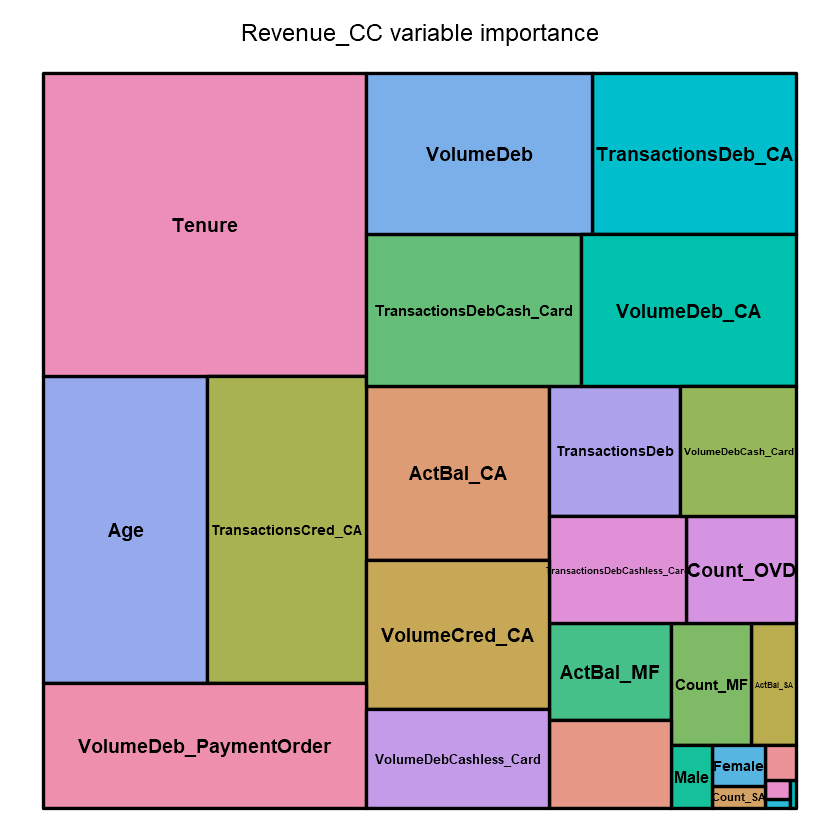

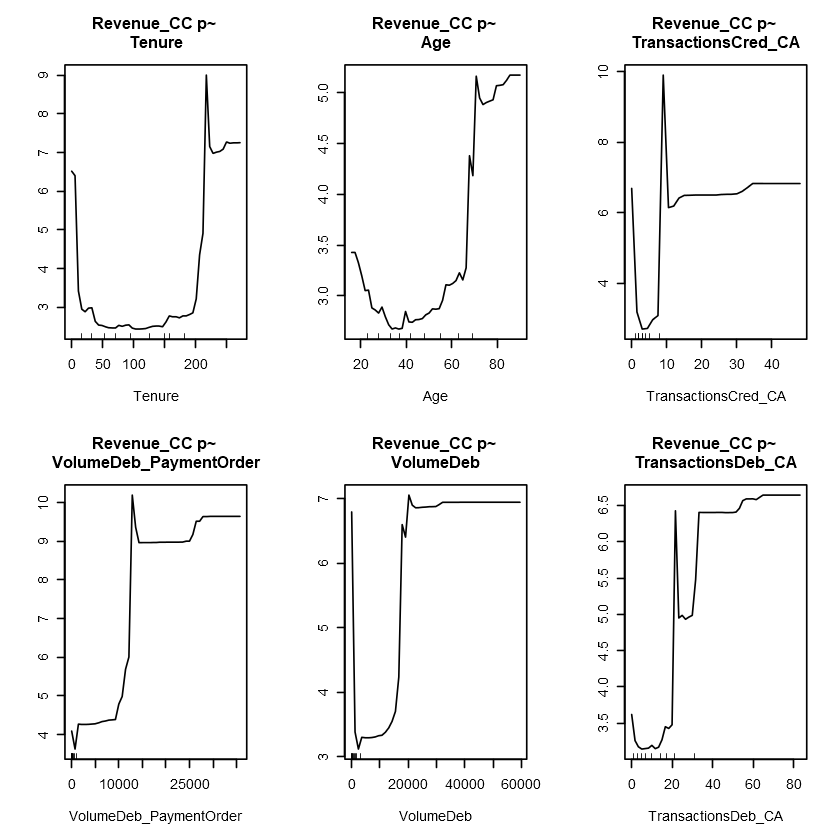

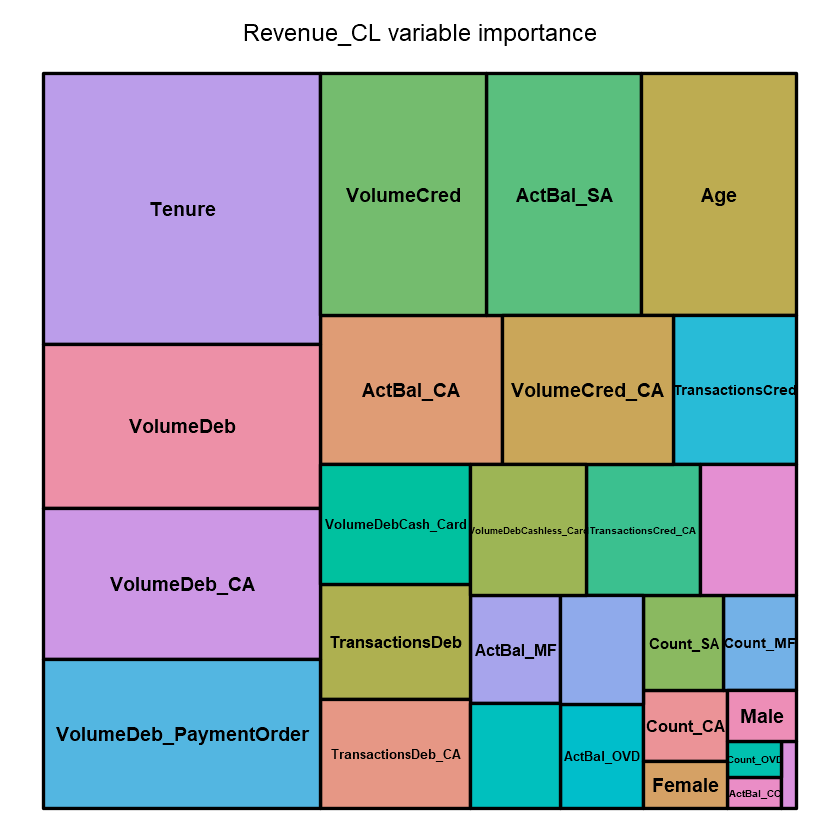

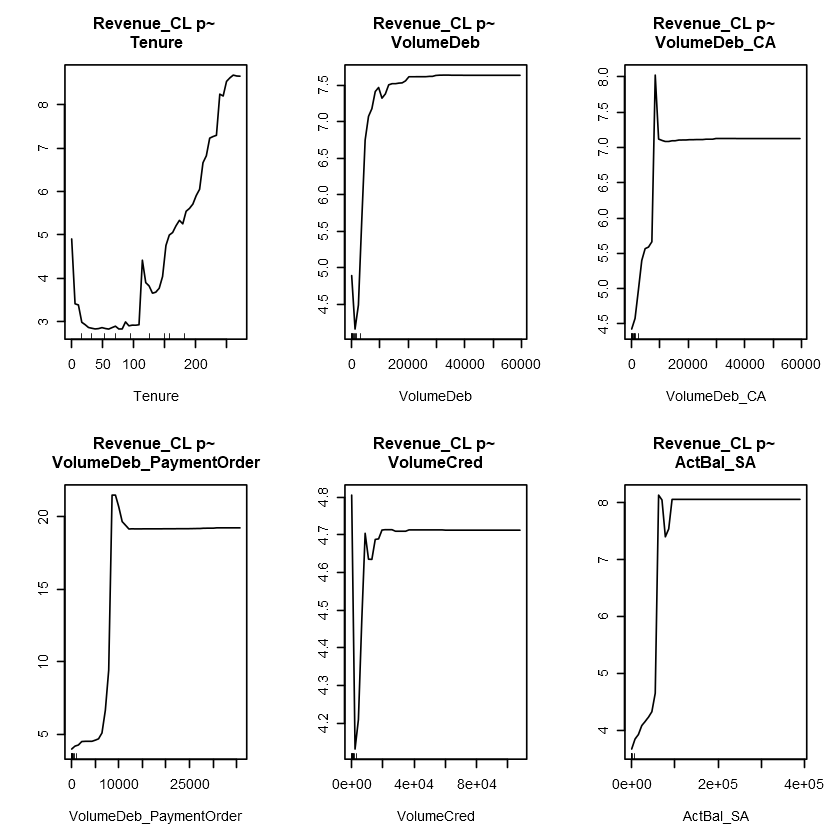

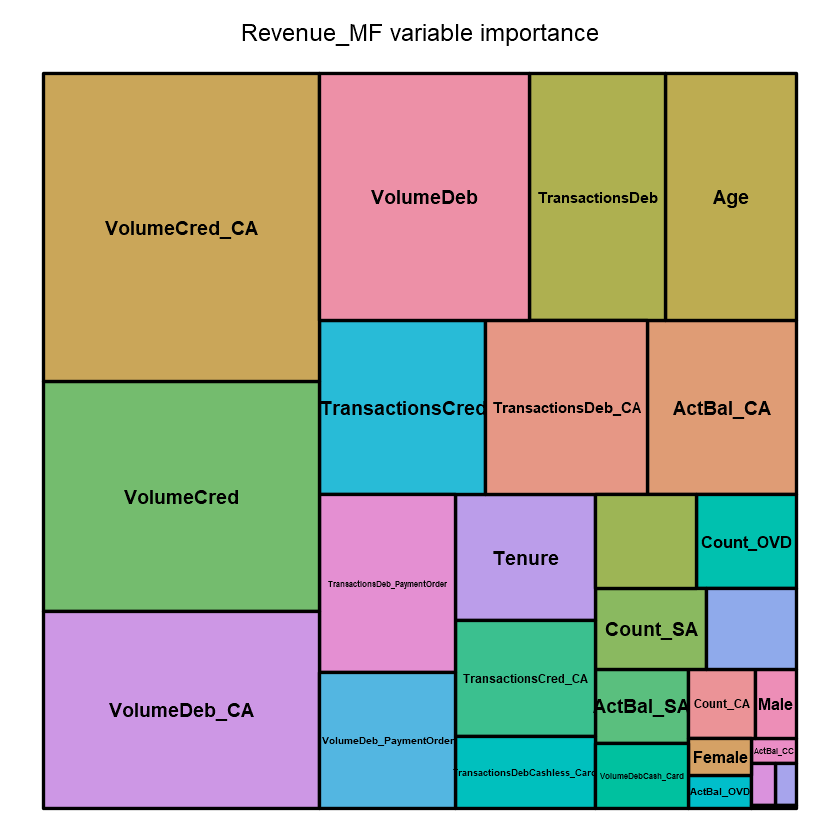

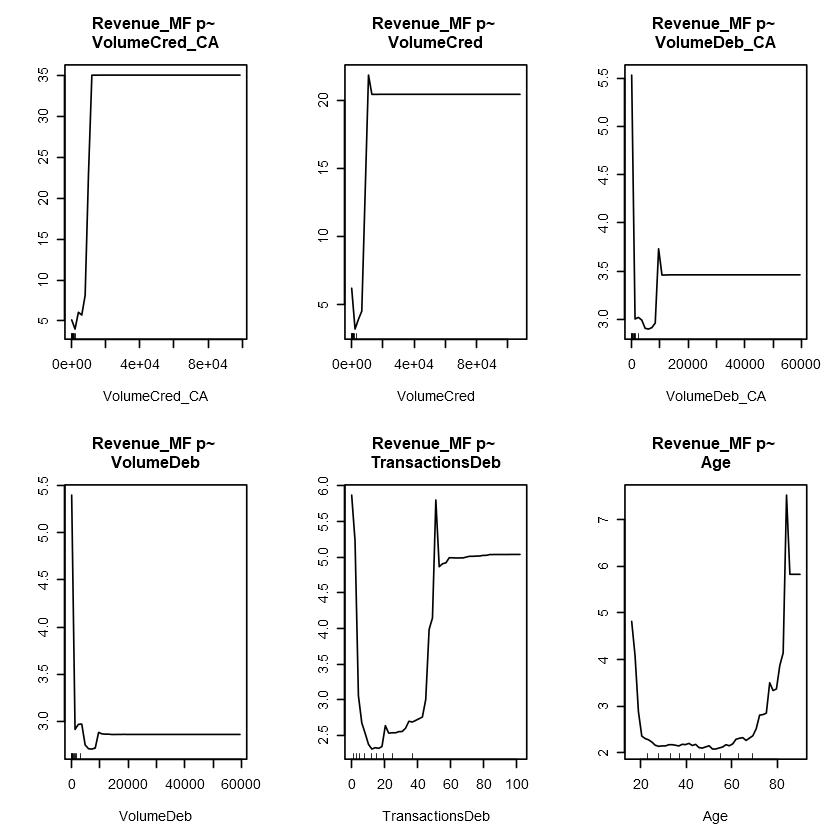

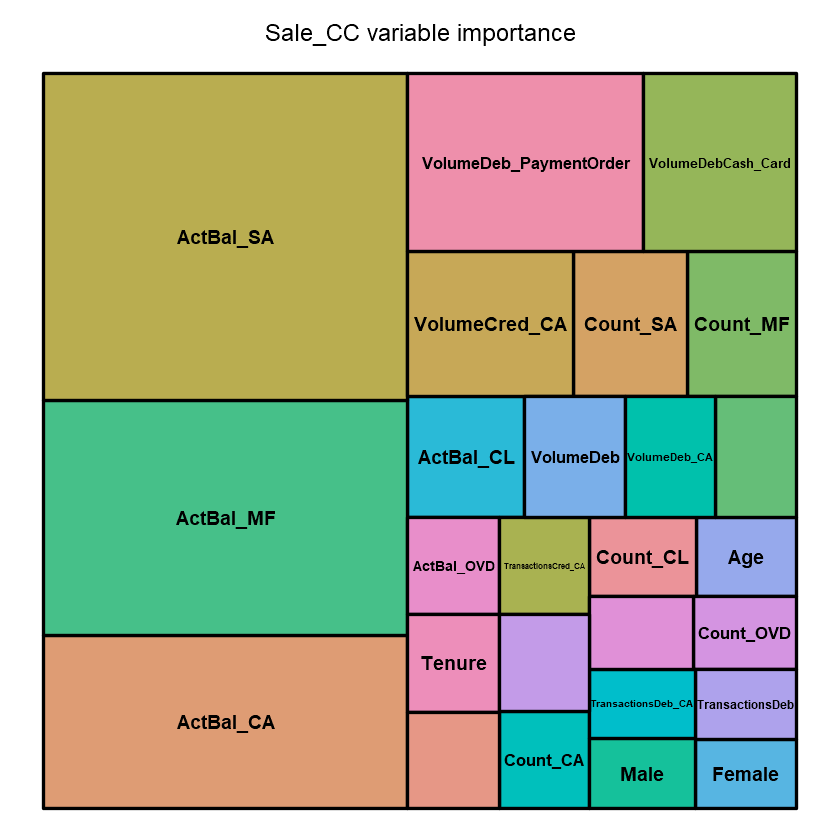

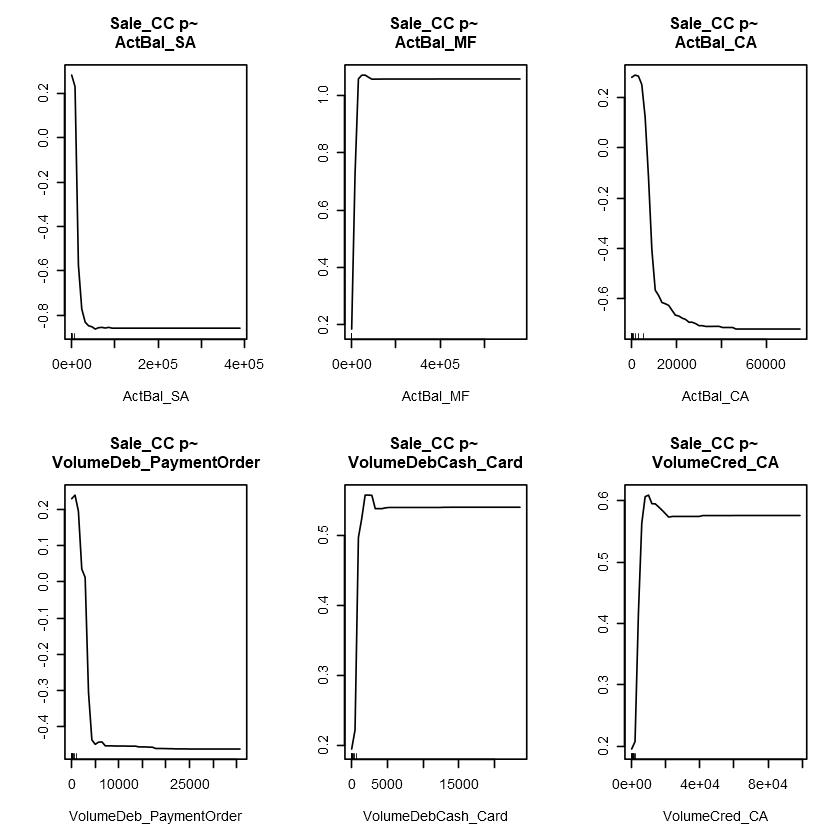

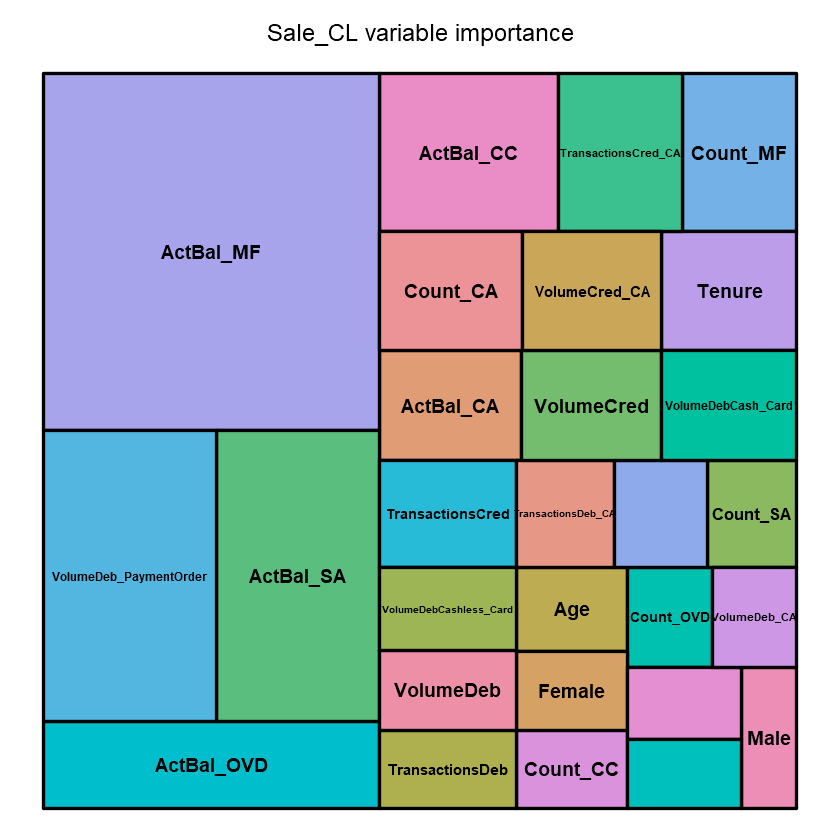

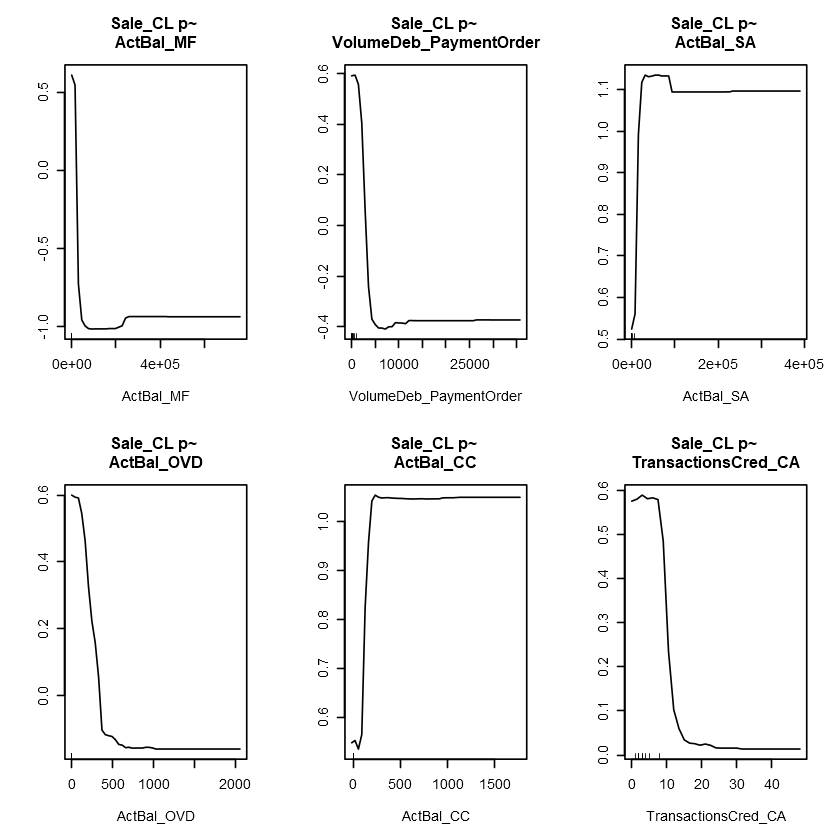

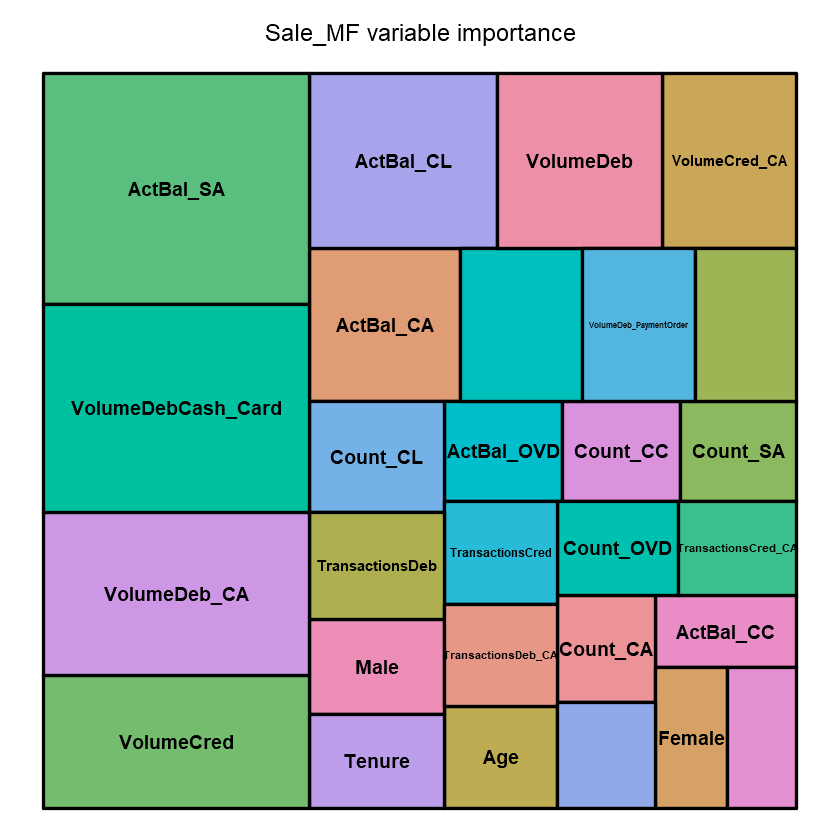

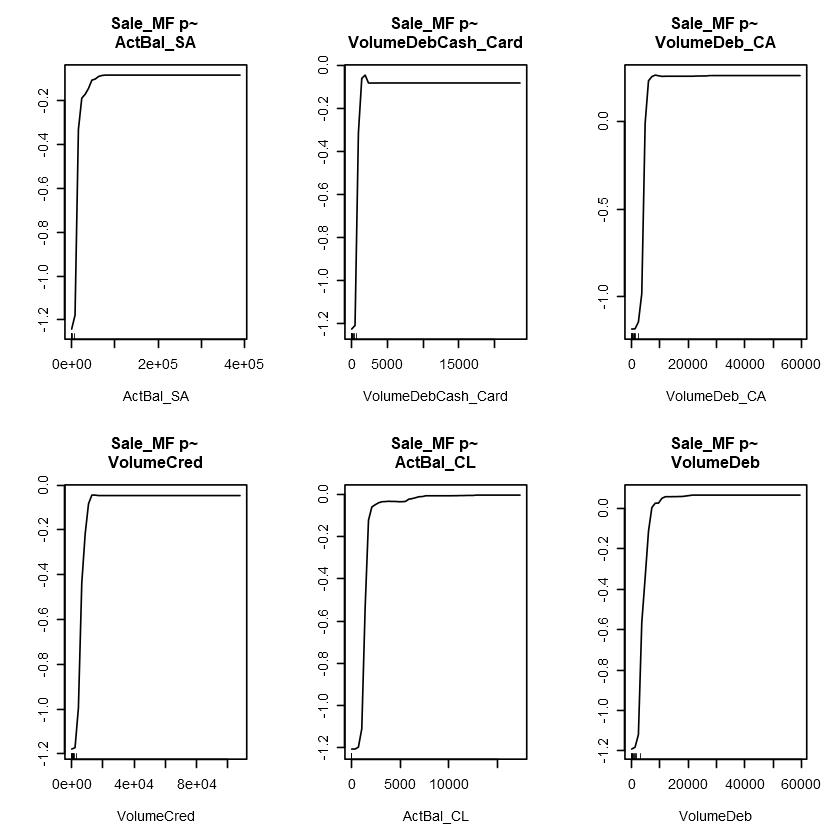

In [12]:
models <- ls(all=TRUE)[grepl(pattern='^model_', ls(all=TRUE))]
for (i in models) {
    temp0 <- paste('varImp <- importance(', i,')', sep='')
    eval(parse(text=temp0))
    temp1 <- rownames(varImp)[order(varImp, decreasing=TRUE)]
    temp2 <- data.frame(variable=rownames(varImp), importance=as.numeric(varImp))
    treemap(dtf=temp2, index='variable', vSize='importance', 
            title=paste(gsub(pattern='model_',replace='',i), ' variable importance', sep=''))
    op <- par(mfrow=c(2, 3))
    for (j in 1:6) {
         temp3 <- paste('partialPlot(', i, ', trainSet, temp1[j], xlab=temp1[j],main=paste(gsub(pattern="model_",replace="",i),
         " p~ \n", temp1[j], sep=""))', sep='')
         eval(parse(text=temp3))
    }
    par(op)
}

### Prediction of Client Response to Different Offers

In [13]:
models <- ls(all=TRUE)[grepl(pattern='^model_', ls(all=TRUE))]
for (i in models) {
    if (grepl(pattern='Revenue', i)) {
       temp0 <- paste('pred <- predict(', i,', newdata=newSet)', sep='')
    } else {
       temp0 <- paste('pred <- predict(', i,', newdata=newSet, type="prob")[,"1"]', sep='')
    }
    eval(parse(text=temp0))
    Client <- newSet$Client
    temp1 <- paste('temp2 <- data.frame(Client = Client, ',gsub(pattern='^model', replace='pred', i),' = pred)', sep='')
    eval(parse(text=temp1))
    if (i == models[1]) {
       predDF <- temp2
    } else {
       predDF <- merge(predDF, temp2, by='Client', all=TRUE)
    }
}


### Decision on which product to offer which clients based on the maximum expected revenue
Expected revenue is the probability to avail a product multiplied by the forecasted revenue when availing that product. The expected revenue was computed for each of the products. The product with the highest expected revenue should be offered to the client. The highest expected revenue is the expected revenue when the recommended product is offered to the client. Ninety-six clients were included in the list of clients to be exposed to direct marketing campaigns. The expected revenue of this strategy is 834.66 Euros.

In [14]:
predDF$expectedRevenue_CC <- predDF$pred_Revenue_CC * predDF$pred_Sale_CC
predDF$expectedRevenue_CL <- predDF$pred_Revenue_CL * predDF$pred_Sale_CL
predDF$expectedRevenue_MF <- predDF$pred_Revenue_MF * predDF$pred_Sale_MF
predDF$expectedRevenue <- apply(predDF[,colnames(predDF)[grepl(pattern='^expectedRevenue_', colnames(predDF))]], MARGIN=1, 
                                FUN=max)
predDF$recommendedOffer <- apply(predDF[,colnames(predDF)[grepl(pattern='^expectedRevenue_', colnames(predDF))]], MARGIN=1, 
                                 FUN=function(x) gsub(pattern='expectedRevenue_', replace='',names(which.max(x))))
predDF <- predDF[order(predDF$expectedRevenue, decreasing=TRUE),]
predDF$target <- 'No'
predDF$target[1:floor(dim(predDF)[1] * 0.15)] <- 'Yes'
head(predDF[predDF$target == 'Yes',],10)
print(sum(predDF$expectedRevenue[1:floor(dim(predDF)[1] * 0.15)]))
write.table(x=predDF, file='targetList.csv', sep=',', row.names=FALSE, col.names=TRUE)

,Client,pred_Revenue_CC,pred_Revenue_CL,pred_Revenue_MF,pred_Sale_CC,pred_Sale_CL,pred_Sale_MF,expectedRevenue_CC,expectedRevenue_CL,expectedRevenue_MF,expectedRevenue,recommendedOffer,target
544,766,3.659488,1.573105,46.442598,0.146,0.080,0.604,0.5342853,0.1258484,28.051329,28.05133,MF,Yes
298,206,28.809492,6.167999,8.566936,0.956,0.078,0.486,27.5418746,0.4811039,4.163531,27.54187,CC,Yes
232,1508,1.977283,4.281546,41.852290,0.454,0.102,0.554,0.8976864,0.4367177,23.186168,23.18617,MF,Yes
579,84,58.459836,4.675076,6.693758,0.362,0.434,0.920,21.1624607,2.0289831,6.158257,21.16246,CC,Yes
210,1460,65.509503,2.778371,2.084904,0.306,0.268,0.898,20.0459078,0.7446034,1.872244,20.04591,CC,Yes
174,1389,23.927272,2.414328,3.980005,0.820,0.286,0.798,19.6203630,0.6904977,3.176044,19.62036,CC,Yes
43,1093,4.351736,7.121964,28.594758,0.568,0.084,0.642,2.4717861,0.5982450,18.357835,18.35783,MF,Yes
294,197,21.314720,12.602979,5.788066,0.820,0.124,0.270,17.4780704,1.5627694,1.562778,17.47807,CC,Yes
428,488,22.741527,2.765521,1.053835,0.640,0.234,0.946,14.5545772,0.6471319,0.996928,14.55458,CC,Yes
327,265,1.356338,6.145449,14.906710,0.296,0.360,0.976,0.4014762,2.2123618,14.548949,14.54895,MF,Yes


[1] 834.6581
